In [113]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import codecs
import imblearn
import re
import nltk
import string

from imblearn.over_sampling import SMOTE

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

import warnings
warnings.filterwarnings("ignore")

In [114]:
with codecs.open('spam.csv', 'r', encoding='ISO-8859-1') as f:
  data_raw = pd.read_csv(f)
spam = data_raw.copy()
spam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [115]:
spam.tail()
#unnamed 2 3 and 4 are useless they just contain random words which prolly would deter the algo more than help it

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN
5571,ham,Rofl. Its true to its name,NaN,NaN,NaN


In [116]:
spam.rename(columns={"v1":"Category", "v2":"Message"}, inplace=True)
spam.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1, inplace=True)

In [117]:
spam["is_spam"] = spam["Category"].map({'ham': 0, "spam": 1})
spam.head()

,Category,Message,is_spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


Text(0, 0.5, 'Number of Data points')

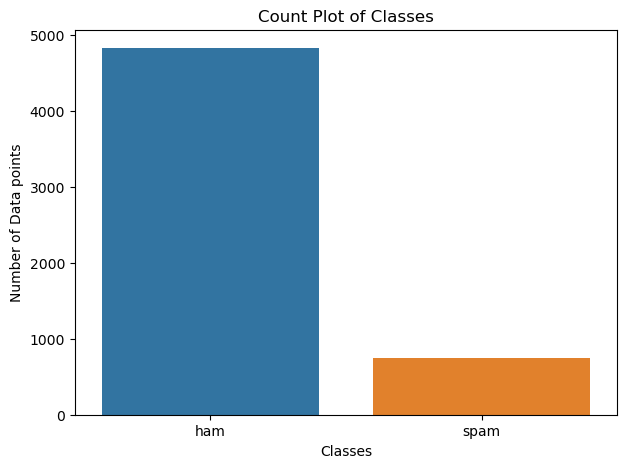

In [118]:
plt.figure(figsize=(7,5))

fig = sns.countplot(x = spam['Category'])
fig.set_title("Count Plot of Classes")
fig.set_xlabel("Classes")
fig.set_ylabel("Number of Data points")

**The data is "Imbalanced" so we Upsample it prolly later**



Now we do Feature Engineering hehe

In [119]:
spam["no_of_chars"] = spam["Message"].apply(len)
spam["no_of_words"]=spam.apply(lambda row: nltk.word_tokenize(row["Message"]), axis=1).apply(len)
spam["no_of_sents"]=spam.apply(lambda row: nltk.sent_tokenize(row["Message"]), axis=1).apply(len)

spam.describe().T

,count,mean,std,min,25%,50%,75%,max
is_spam,5572.0,0.134063,0.340751,0.0,0.0,0.0,0.0,1.0
no_of_chars,5572.0,80.118808,59.690841,2.0,36.0,61.0,121.0,910.0
no_of_words,5572.0,18.699390,13.741932,1.0,9.0,15.0,27.0,220.0
no_of_sents,5572.0,1.996411,1.520159,1.0,1.0,1.5,2.0,38.0


<Figure size 1200x800 with 0 Axes>

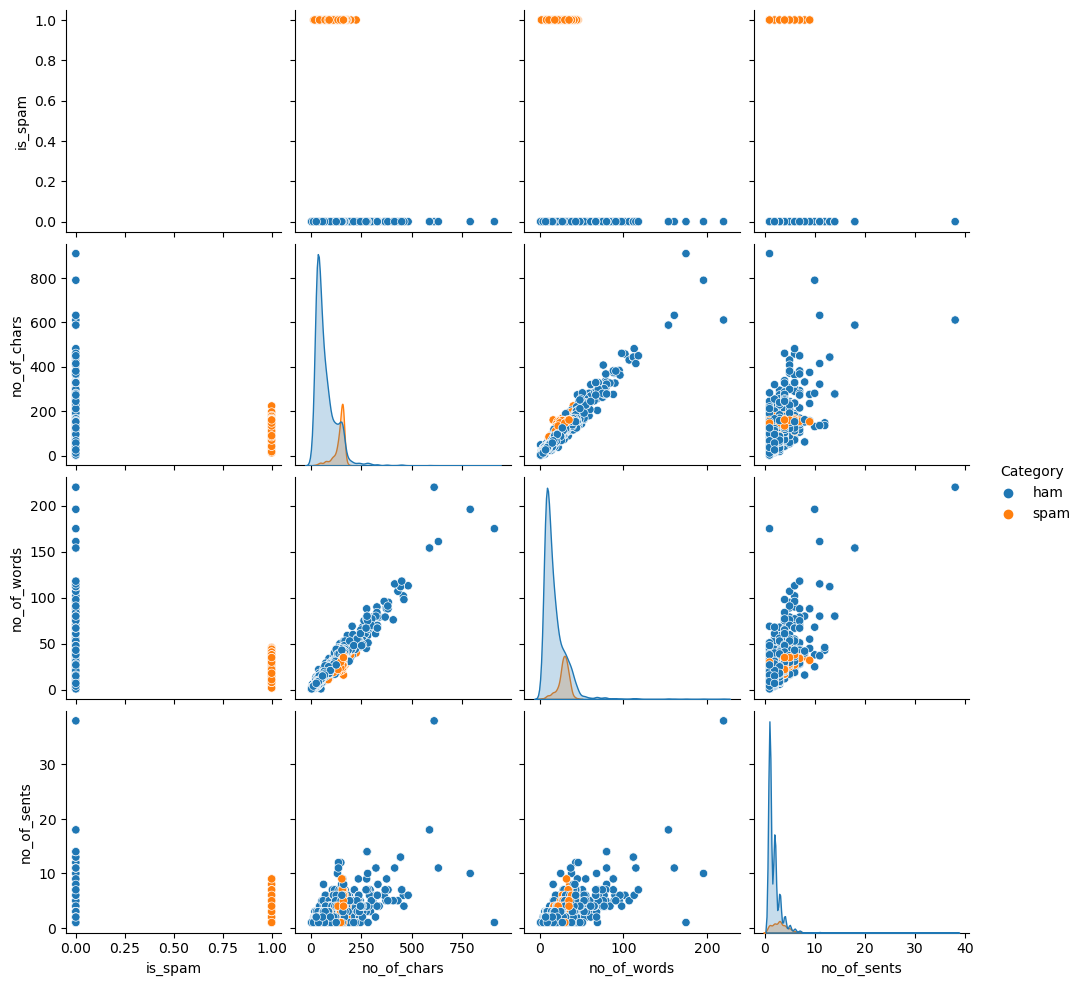

In [120]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=spam, hue="Category")
plt.show(fg)

No of characters seems like it can be capped upto 500 cuz the rest feel pretty outlier-ish

No of sentences can be capped upto 20 too as there is one single outlier

<Figure size 1200x800 with 0 Axes>

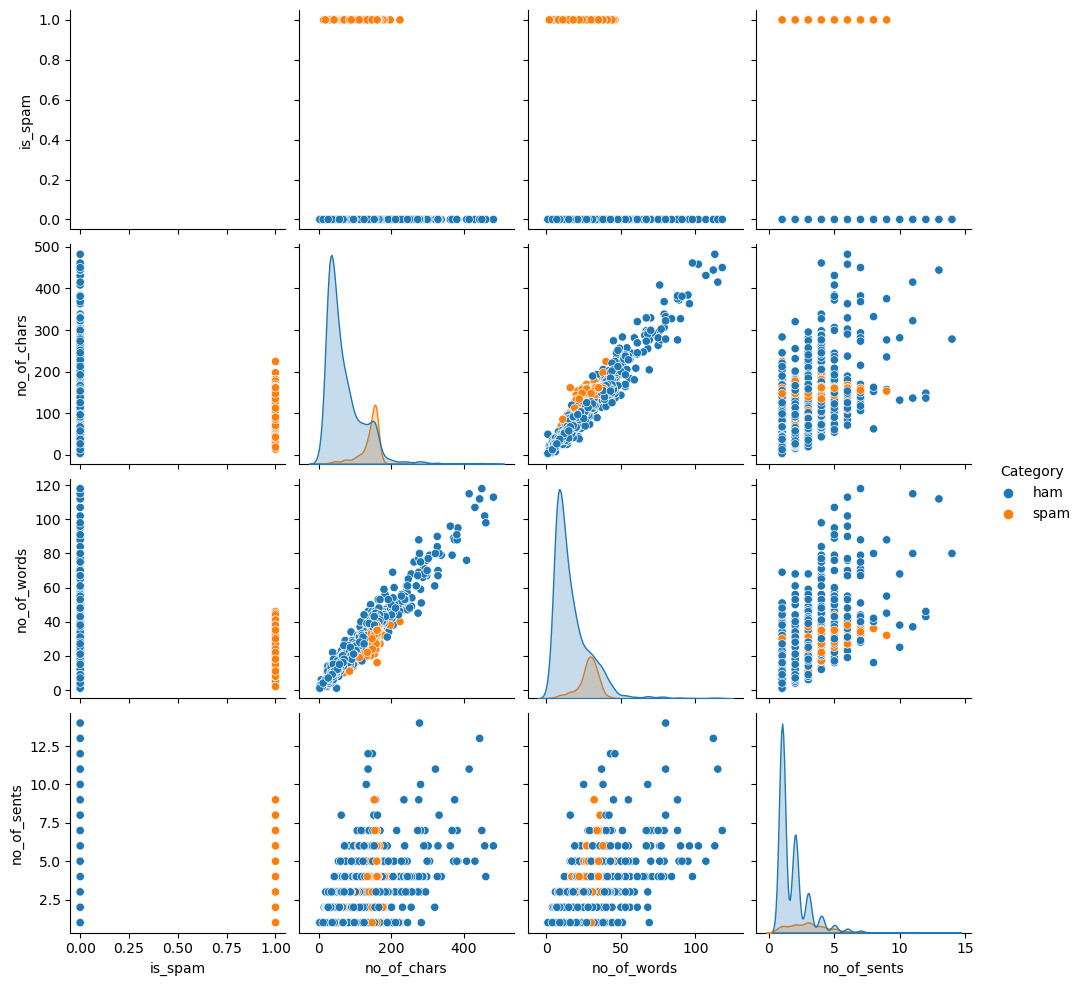

In [121]:
spam = spam[(spam["no_of_chars"]<500)]
spam = spam[(spam["no_of_sents"]<25)]

plt.figure(figsize=(12,8))
fg = sns.pairplot(data=spam, hue="Category")
plt.show(fg)

# Now to do NLP preprocessing :p

cleaning -> tokenization -> rmv stopwords -> lemmatization/stemming -> vectorization

lemmatization is slow but more accurate(provides language accurate resluts)
stemming is fast but works under weird assumptions(simply removes prefix and suffix) and sometimes not reliable

In [122]:
def Clean(Text):
  sms = re.sub('[^a-zA-Z]', ' ', Text) #Replacing all non-alphabetic characters with a space
  sms = sms.lower()
  sms = sms.split()
  sms = ' '.join(sms)
  return sms

spam["clean_msg"] = spam["Message"].apply(Clean)

In [123]:
spam["token_msg"]=spam.apply(lambda row: nltk.word_tokenize(row["clean_msg"]), axis=1)

In [124]:
def remove_stopwords(text):
  stop_words = set(stopwords.words("english"))
  filtered_text = [word for word in text if word not in stop_words]
  return filtered_text

spam["nonstop_msg"] = spam["token_msg"].apply(remove_stopwords)

In [125]:
#nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def lemmatize_word(text):
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in text]
    return lemmas

spam["lemma_msg"] = spam["nonstop_msg"].apply(lemmatize_word)
spam.head()

,Category,Message,is_spam,no_of_chars,no_of_words,no_of_sents,clean_msg,token_msg,nonstop_msg,lemma_msg
0,ham,"Go until jurong point, crazy.. Available only ...",0,111,24,2,go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,0,29,8,2,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,37,2,free entry in a wkly comp to win fa cup final ...,"[free, entry, in, a, wkly, comp, to, win, fa, ...","[free, entry, wkly, comp, win, fa, cup, final,...","[free, entry, wkly, comp, win, fa, cup, final,..."
3,ham,U dun say so early hor... U c already then say...,0,49,13,1,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, early, hor, u, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61,15,1,nah i don t think he goes to usf he lives arou...,"[nah, i, don, t, think, he, goes, to, usf, he,...","[nah, think, goes, usf, lives, around, though]","[nah, think, go, usf, live, around, though]"


In [126]:
corpus = []
for i in spam["lemma_msg"]:
    msg = ' '.join([row for row in i])
    corpus.append(msg)

Now we do train-test split before vectorization or else there will be biased outcomes due to data leakage

In [127]:
X_train, X_dev, y_train, y_dev = train_test_split(corpus, spam['is_spam'], test_size=0.2, random_state=42)

Using corpus here instead of spam['lemma_msg'] because spam['lemma_msg'] contains lists of words. Vectorization methods like TfidfVectorizer require input as cohesive strings of text, not lists. Therefore, each list of lemmatized words is converted into a single string and stored in the corpus list to ensure proper vectorization.

In [128]:
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_dev_tfidf = vectorizer.transform(X_dev)

Now to the easy stuff

In [129]:
model_NB = MultinomialNB()
model_NB.fit(X_train_tfidf, y_train)

y_pred_NB = model_NB.predict(X_dev_tfidf)
print(classification_report(y_pred_NB, y_dev, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       994
           1       0.74      1.00      0.85       120

    accuracy                           0.96      1114
   macro avg       0.87      0.98      0.91      1114
weighted avg       0.97      0.96      0.96      1114



In [130]:
model_svc = LinearSVC()

model_svc.fit(X_train_tfidf, y_train)
y_pred_svc = model_svc.predict(X_dev_tfidf)
print(classification_report(y_pred_svc, y_dev))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       962
           1       0.92      0.98      0.95       152

    accuracy                           0.99      1114
   macro avg       0.96      0.98      0.97      1114
weighted avg       0.99      0.99      0.99      1114



In [131]:
model = LogisticRegression()
model.fit(X_train_tfidf ,y_train)
y_pred = model.predict(X_dev_tfidf)
print(classification_report(y_pred ,y_dev, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97       997
           1       0.71      0.98      0.82       117

    accuracy                           0.96      1114
   macro avg       0.85      0.97      0.90      1114
weighted avg       0.97      0.96      0.96      1114



All of these seem _good enough_ due to high recall value of both the classes for all these models, meaning the model is very good at identifying all instances of class 0 and class 1.

However, for class 1, the precision is quite less compared with the precision from class 0 for 2 of the 3 models, meaning tthat there are some false positives.

The F1-score is around 0.8 for two of the models, which is again, _good enough_ but indicates room for improvement in precision. Balancing the dataset (or) adding weights to the classes while declaring the models would've increased the precision and F1 score of class 1.